In [1]:
import numpy as np
from LS30 import dde_solve

ModuleNotFoundError: No module named 'LS30'

In [2]:
@interact(n=slider(2, 20, 1, default=2, label="$n$"))
def hpg_interact(n):
    tmax = 150
    ymax = 7
    vectorfield(H, P, G) = (1 / (1 + G^n) - 0.2*H, H - 0.2*P, P - 0.2*G)
    t_range = srange(0, tmax, 0.01)
    solution = desolve_odeint(vectorfield, (0.5, 1, 1), t_range, [H, P, G])
    solution = np.insert(solution, 0, t_range, axis=1)

    p1 = list_plot(solution[:,(0,1)], plotjoined=True, color="gold", legend_label="$H$")
    p1 += list_plot(solution[:,(0,2)], plotjoined=True, color="blue", legend_label="$P$")
    p1 += list_plot(solution[:,(0,3)], plotjoined=True, color="red", legend_label="$G$", ymin=0, ymax=ymax, 
                    axes_labels=("$t$", "Hormone\nconcentrations"), aspect_ratio=2/3*tmax/ymax)

    p2 = plot(1 / (1 + G^n), (G, 0, 3), thickness=2, ymin=0, ymax=1.3)
    p2 += line(((0, 1), (3, 1)), color="red", linestyle="dashed")
    p2 += text(r"$\frac{1}{1 + G^{%d}}$" % n, (2.2, 0.5), color="black", fontsize=20, 
               axes_labels=(r"$G$", ""), title="Production rate of GnRH")
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function hpg_interact at 0x7fa8b804d3a0> with 1 widget
  n: TransformIntSlider(value=2, …

In [3]:
var("r_1, r_2, k, j, w, d")
def holling_tanner_hopf(vary):
    field(N, P) = ( r_1*N*(1 - N/k) - w*P*N/(d + N), r_2*P*(1 - j*P/N) )
    J = jacobian(field, (N, P))
    b = (d - k + k*w/j/r_1)/2
    N_eq = sqrt(b^2 + d*k) - b
    P_eq = N_eq/j
    J_eq = J(N_eq, P_eq)

    params = {
        r_1: 0.4,      # Natural per-capita growth rate of the prey population
        r_2: 0.03,     # Natural per-capita growth rate of the predator population
        j:  150,       # Size of prey population needed to support each predator
        w:  300,       # Maximum rate at which one predator consumes prey (per year)
        d:  1400,      # Prey population at which the predation rate will be half of that maximum
        k:  3000,      # Maximum prey population supported by the environment (carrying capacity)
    }
    param_ranges = {
        r_1: (0.2, 0.8, 0.01),
        r_2: (0.01, 0.10, 0.001),
        j:   (50, 300, 10),
        w:   (200, 800, 10),
        d:   (300, 2000, 20),
        k:   (1800, 5000, 10),
    }
    t_range = srange(0, 8000, 0.1)
    initial_state = (220, 0.8)

    @interact(value=slider(*param_ranges[vary], default=params[vary], label="${}$".format(vary)))
    def update(value):
        params[vary] = value
        myfield = field.subs(params)
        N0, P0 = (N_eq.subs(params), P_eq.subs(params))
        realpart = J_eq.subs(params).trace()/2
        p1 = plot_vector_field(myfield, (N, 0, 2000), (P, 0, 4), color="limegreen", frame=False)
        spiralin = desolve_odeint(myfield, initial_state, t_range, [N, P])
        if realpart > 0:
            p1 += list_plot(spiralin[:-4000], plotjoined=True, color="red")
            near_eqpt = (N0, P0 + 0.1)
            spiralout = desolve_odeint(myfield, near_eqpt, t_range, [N, P])
            p1 += list_plot(spiralout, plotjoined=True, color="fuchsia")
            p1 += list_plot(spiralin[-4000:], plotjoined=True, color="purple", thickness=2)
        else:
            p1 += list_plot(spiralin, plotjoined=True, color="red")
        p1 += point([(N0, P0)], size=40, color="purple", xmax=2000, ymax=4, 
                    axes_labels=("$N$ (Prey)", "$P$ (Predators)"), aspect_ratio=2/3*2000/4)

        saturating = (w*N/(d + N)).subs(params)
        p2 = plot(saturating, (N, 0, 3000), thickness=2, ymin=0, ymax=400, aspect_ratio=0.5*3000/400)
        p2 += line(((0, params[w]), (3000, params[w])), color="red", linestyle="dashed")
        p2 += text(r"$w$", (100, params[w]), color="red", 
                   fontsize=16, horizontal_alignment="left", vertical_alignment="bottom")
        p2 += line(((0, params[w]/2), (params[d], params[w]/2), (params[d], 0)), color="green", 
                   linestyle="dotted")
        p2 += text(r"$N = d$", (params[d], 0), color="green", 
                   fontsize=16, horizontal_alignment="left", vertical_alignment="bottom")
        p2 += text(r"$\frac{w}{2}$", (0, params[w]/2), color="green", 
                   fontsize=16, horizontal_alignment="left", vertical_alignment="bottom", 
                   axes_labels=(r"$N$", ""), title="per-capita predation rate")
        both = multi_graphics([(p1, (0, 0, 0.6, 1)), 
                               (p2, (0.65, 0.6, 0.35, 0.2))])
        both.show(figsize=9)


In [4]:
holling_tanner_hopf(d)

Interactive function <function holling_tanner_hopf.<locals>.update at 0x7fa68da0e820> with 1 widget
  value: T…

In [5]:
@interact(n=slider(1, 10, 1, default=2, label=r"$n$ (steepness)"), 
          delay=slider(0, 0.9, 0.02, default=0.1, label=r"$\tau$ (delay)"), 
          tmax=slider([4, 10, 20, 50], label=r"$t_{max}$"))
def co2_ventilation_sigmoid(n, delay, tmax):
    X, X_tau = var("X, X_tau")
    l = 6
    v_max = 80
    a = 0.2
    history = 4
    timestep = 0.01
    sigmoid = v_max * X_tau^n/(1 + X_tau^n)
    diffeq = l - sigmoid * a*X
    label = r"$X'(t) = %d - %d X(t) \cdot \frac{X(t - %.02f)^{%d}}{1 + X(t - %.02f)^{%d}}$"
    label = label % (l, a*v_max, delay, n, delay, n)

    solution = dde_solve(diffeq, X, {X_tau: (X, delay)}, history, tmax, timestep)
    p1 = list_plot(solution, plotjoined=True, ymin=0, ymax=6, axes_labels=("$t$", "$X$"))
    p1 += text(label, (tmax/2, 5), color="black", fontsize=20, aspect_ratio=tmax/8)

    p2 = plot(sigmoid, (X_tau, 0, 3), thickness=2, 
              ymax=1.5*v_max, axes_labels=(r"$X$", ""), title="Breathing rate")
    p2 += line(((0, v_max), (3, v_max)), color="red", linestyle="dashed")
    both = multi_graphics([(p1, (0, 0, 0.65, 1)), 
                           (p2, (0.75, 0.6, 0.25, 0.2))])
    both.show(figsize=9)


Interactive function <function co2_ventilation_sigmoid at 0x7fa68d7d23a0> with 3 widgets
  n: TransformIntSlid…

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **Hopf bifurcation diagram of the CO$_2$ ventilation model**

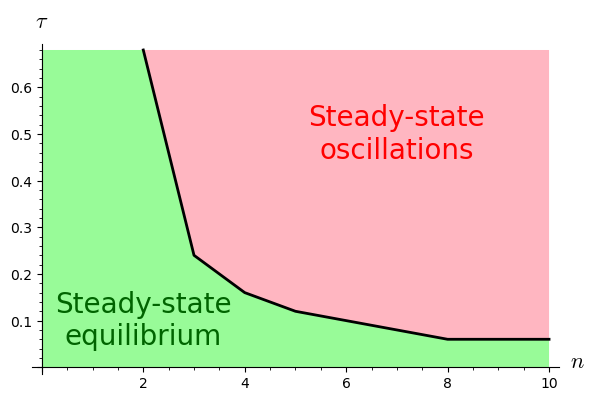

In [6]:
min_delay_for_oscillations = {
    2: 0.68,
    3: 0.24,
    4: 0.16,
    5: 0.12,
    6: 0.10,
    7: 0.08,
    8: 0.06,
    9: 0.06,
    10: 0.06,
}

xmax = max(min_delay_for_oscillations.keys())
ymax = max(min_delay_for_oscillations.values())
vertices = sorted(list(min_delay_for_oscillations.items()))

p = list_plot(vertices, plotjoined=True, thickness=2, color="black")
p += polygon([(xmax,0), (0,0), (0,ymax)] + vertices, color="palegreen")
p += polygon([(xmax,ymax)] + vertices, color="lightpink")
p += text("Steady-state\noscillations", (7, 0.5), color="red", fontsize=20)
p += text("Steady-state\nequilibrium", (2, 0.1), color="darkgreen", fontsize=20)
p.show(aspect_ratio="auto", axes_labels=("$n$", "$\\tau$"))